In [86]:
import numpy as np
import torch
import scipy
import time
import sys
sys.path.insert(1, './PSM_V1')
from sobolev import Sobolev
from solver import Solver
from utils import matmul
from diffeomorphisms import hyper_rect
import surrogates
import matplotlib.pyplot as plt
from pinnutils import PINN
#from pinnutils import PINNN

In [87]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)

In [88]:
# Tests
# a=-1.0, b=1.0, q=3, sob_2d(deg=30), sob_1d(deg=100), model(n=30, p=np.inf), s=[0,-1], optimizer:LBFGS

2D Incompressible Navier Stokes
$$
   \Biggr\{\begin{array}{rll}
       -\nu\Delta u(x,y) + (u(x,y)\cdot\nabla)u(x,y) + \nabla p(x,y)&= 0 &,  \forall (x,y)\in\Omega  \\
        \nabla\cdot u (x,y)&= 0 &,  \forall (x,y)\in\Omega \\
         u(x,y)  -g(x,y)     &= 0   &,  \forall (x,y)\in\partial\Omega\,
\end{array}
$$

In [89]:
rect = np.array([[-1.0, 1.0], [-1.0, 1.0]])

nu = 1/40
lam = 1/(2*nu)-np.sqrt(1/(2*nu)**2+4*np.pi**2) 
#def u1(x, y):
#    return -np.sin(np.pi*x)*np.cos(np.pi*y)
def u1(x, y):
    return 1-np.exp(lam*x)*np.cos(2*np.pi*y)

#def u2(x, y):
#    return np.cos(np.pi*x)*np.sin(np.pi*y)
def u2(x, y):
    return lam/(2*np.pi)*np.exp(lam*x)*np.sin(2*np.pi*y)

#def p(x, y):
#    return x*np.exp(np.pi*y)
def p(x, y):
    return 1/2*(1-np.exp(2*lam*x))

def term1(x, y):
    return np.pi*np.cos(np.pi*x)*np.cos(np.pi*y)

def term2(x, y):
    return np.pi*np.sin(np.pi*x)*np.sin(np.pi*y)

def f1(x, y):
    return ((2*nu*np.pi**2-term1(x,y))*u1(x, y)+\
            term2(x, y)*u2(x, y)+\
            np.exp(np.pi*y))*0
            
def f2(x, y):
    return ((2*nu*np.pi**2+term1(x,y))*u2(x, y)-\
            term2(x, y)*u1(x, y)+\
            np.exp(np.pi*y)*np.pi*x)*0

In [90]:
# Sobolev Cubature
diffeo_2d = hyper_rect(*rect)
diffeo_1d_0 = hyper_rect(rect[0])
diffeo_1d_1 = hyper_rect(rect[1])

sob_2d = Sobolev(deg=30, dim=2, diffeo=diffeo_2d)
sob_1d_0 = Sobolev(deg=100, diffeo=diffeo_1d_0)
sob_1d_1 = Sobolev(deg=100, diffeo=diffeo_1d_1)

dx2, dy2 = torch.tensor(sob_2d.diff.diffs(np.array([[2,0],[0,2]])), dtype = torch.float32)
dx, dy = torch.tensor(sob_2d.diff.diffs(np.array([[1,0],[0,1]])), dtype = torch.float32)

### Ground Truth

In [91]:
def gt(x,y):
    return np.cos(lam*x)*np.sin(lam*y)

### Gradient Flow

In [92]:
# |--------------------------------------------|
# |  Operator  |          Formulation          |  
# |------------|-------------------------------|
# | id         |  L2 grad of L2                | 
# | m_inv      |  L2 grad of Sob               |
# | weak m_inv |  L2 grad of weak Sob          |
# | m          |  L2 grad of negative Sob      |
# | weak m     |  L2 grad of weak negative Sob |
# |--------------------------------------------|
#
# For that use:
# -> sob.set_s(s)
# -> sob.metric(rev=False/True, weak=False/True)

In [93]:
# Sobolev Order
sob_2d.set_s(0)
sob_1d_0.set_s(0)

In [94]:
# Data
_, xs_bndr_0 = sob_1d_0.get_xs()
_, xs_bndr_1 = sob_1d_1.get_xs()
xs_plt, xs = sob_2d.get_xs()
grid_2d = sob_2d.get_leja_grid()
xs = torch.tensor(xs)
xs_bdx =  torch.tensor(xs_bndr_0[0])
X_t, Y_t = torch.meshgrid(xs[0],xs[1])
X_pde = torch.tensor(torch.cat((X_t.reshape(-1,1), Y_t.reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
X_bdl = torch.tensor(torch.cat((xs_bdx.reshape(-1,1), rect[1][0]*torch.ones(len(xs_bdx)).reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
X_bdr = torch.tensor(torch.cat((xs_bdx.reshape(-1,1), rect[1][1]*torch.ones(len(xs_bdx)).reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
Y_bdl = torch.tensor(torch.cat((rect[0][0]*torch.ones(len(xs_bdx)).reshape(-1,1),xs_bdx.reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
Y_bdr = torch.tensor(torch.cat((rect[0][1]*torch.ones(len(xs_bdx)).reshape(-1,1),xs_bdx.reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
u1_bdyl = torch.tensor(u1(xs_bndr_0[0], rect[1][0].reshape(-1)), dtype = torch.float32)
u1_bdyr = torch.tensor(u1(xs_bndr_0[0], rect[1][1].reshape(-1)), dtype = torch.float32)
u1_bdxl= torch.tensor(u1(rect[0][0].reshape(-1,1), xs_bndr_1[0]).reshape(-1), dtype = torch.float32)
u1_bdxr= torch.tensor(u1(rect[0][1].reshape(-1,1), xs_bndr_1[0]).reshape(-1), dtype = torch.float32)
u2_bdyl = torch.tensor(u2(xs_bndr_0[0], rect[1][0].reshape(-1)), dtype = torch.float32)
u2_bdyr = torch.tensor(u2(xs_bndr_0[0], rect[1][1].reshape(-1)), dtype = torch.float32)
u2_bdxl= torch.tensor(u2(rect[0][0].reshape(-1,1), xs_bndr_1[0]).reshape(-1), dtype = torch.float32)
u2_bdxr= torch.tensor(u2(rect[0][1].reshape(-1,1), xs_bndr_1[0]).reshape(-1), dtype = torch.float32)
w_2d = torch.tensor(sob_2d.get_leja_weights(), dtype = torch.float32)
w_1d = torch.tensor(sob_1d_0.get_leja_weights(), dtype = torch.float32)
f_1 = torch.tensor(f1(grid_2d[:,0], grid_2d[:,1]))
f_2 = torch.tensor(f2(grid_2d[:,0], grid_2d[:,1]))

/tmp/ipykernel_153539/818485077.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_pde = torch.tensor(torch.cat((X_t.reshape(-1,1), Y_t.reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
/tmp/ipykernel_153539/818485077.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_bdl = torch.tensor(torch.cat((xs_bdx.reshape(-1,1), rect[1][0]*torch.ones(len(xs_bdx)).reshape(-1,1)),1), dtype = torch.float32, requires_grad = True)
/tmp/ipykernel_153539/818485077.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_bdr = torch.tens

In [95]:
eq1 = lambda u1, u2, p: -matmul(dx2+dy2, u1)+\
                        u1*matmul(dx, u1)/nu+u2*matmul(dy, u1)/nu+\
                        matmul(dx, p)/nu-f_1/nu
eq2 = lambda u1, u2, p: -matmul(dx2+dy2, u2)+\
                        u1*matmul(dx, u2)/nu+u2*matmul(dy, u2)/nu+\
                        matmul(dy, p)/nu-f_2/nu

crit_dmn_0 = lambda u1, u2, p: sob_2d.loss(eq1(u1, u2, p), weak=True)\
                                +sob_2d.loss(eq2(u1, u2, p), weak=True)

crit_dmn_1 = lambda u1, u2, p: sob_2d.l2_loss(eq1(u1, u2, p))\
                                +sob_2d.l2_loss(eq2(u1, u2, p))

eq3 = lambda u1, u2, p: matmul(dx, u1)+matmul(dy, u2)

In [96]:
u1_e = torch.tensor(u1(grid_2d[:,0], grid_2d[:,1]), dtype = torch.float32)
u2_e = torch.tensor(u2(grid_2d[:,0], grid_2d[:,1]), dtype = torch.float32)
p_e = torch.tensor(p(grid_2d[:,0], grid_2d[:,1]), dtype = torch.float32)
                    

/tmp/ipykernel_153539/2518092384.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u1_e = torch.tensor(u1(grid_2d[:,0], grid_2d[:,1]), dtype = torch.float32)
/tmp/ipykernel_153539/2518092384.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u2_e = torch.tensor(u2(grid_2d[:,0], grid_2d[:,1]), dtype = torch.float32)
/tmp/ipykernel_153539/2518092384.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_e = torch.tensor(p(grid_2d[:,0], grid_2d[:,1]), dtype = torch.float32)


In [97]:
TD = np.concatenate([X_pde.detach().numpy(),X_bdl.detach().numpy(), X_bdr.detach().numpy(), Y_bdl.detach().numpy() , Y_bdl.detach().numpy()], 0)
# compute mean and std of training data
X_mean = torch.tensor(np.mean(TD, axis=0, keepdims=True),device=device)
X_std = torch.tensor(np.std(TD, axis=0, keepdims=True),device=device)
seedc = 1

In [98]:
import torch.nn as nn

from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from scipy.interpolate import griddata
from itertools import product, combinations

from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from tqdm import tqdm_notebook as tqdm 
class sine(nn.Module):
    def forward(self,x):
        return torch.sin(x)


In [99]:
def closure(optim):
        optim.zero_grad()
        loss.backward()
        return loss

In [100]:
lam_s = torch.max(torch.linalg.eig(dx2)[0].real)

In [101]:
w_1d = torch.sqrt(w_1d)

In [102]:
u1_net = PINN(sizes=[2,50,50,50,50,1], mean=X_mean, std=X_std, seed=seedc, activation=sine()).to(device)
u2_net = PINN(sizes=[2,50,50,50,50,1], mean=X_mean, std=X_std, seed=seedc, activation=sine()).to(device)
print("#parameters:", sum(p.numel() for p in u1_net.parameters() if p.requires_grad))
n_epochs   = 30000
lamb  = 1
losses_bc  = [];
losses_reg = [];
u1_params = [{'params': u1_net.parameters()}]
u2_params = [{'params': u2_net.parameters()}]
milestones = [[15000,20000]]
optimizer_u1 = torch.optim.Adam(u1_params)
optimizer_u2 = torch.optim.Adam(u2_params)
scheduler_u1 = MultiStepLR(optimizer_u1, milestones[0], gamma=0.1)
scheduler_u2 = MultiStepLR(optimizer_u2, milestones[0], gamma=0.5)
start_time = time.time()
ds = 1
lam_grad = lam_s
lam_b = 1
for epoch in range(n_epochs):
    
    optimizer_u1.zero_grad()
    optimizer_u2.zero_grad()
    uhat_1  = u1_net(X_pde).T[0]
    uhat_2  = u2_net(X_pde).T[0]
    #l_pde   = crit_pde(uhat)
    l_pde = torch.sum(((eq1(uhat_1,uhat_2,p_e)*w_2d)**2))
    l_pde += torch.sum(((eq2(uhat_1,uhat_2,p_e)*w_2d)**2))
    l_pde += torch.sum(((eq3(uhat_1,uhat_2,p_e)*w_2d)**2))
    
    predxl1 = u1_net(X_bdl).T[0]
    predxr1 = u1_net(X_bdr).T[0]
    predyl1 = u1_net(Y_bdl).T[0]
    predyr1 = u1_net(Y_bdr).T[0]
    
    predxl2 = u2_net(X_bdl).T[0]
    predxr2 = u2_net(X_bdr).T[0]
    predyl2 = u2_net(Y_bdl).T[0]
    predyr2 = u2_net(Y_bdr).T[0]
    #l_bc = crit_bdxl(predxl) + crit_bdxr(predxr) + crit_bdyl(predyl) + crit_bdyr(predyr) 
    l1_bc = torch.sum((((predxl1-u1_bdxl)*w_1d)**2))+torch.sum((((predxr1-u1_bdxr)*w_1d)**2))+torch.sum((((predyl1-u1_bdyl)*w_1d)**2))
    l1_bc += torch.sum((((predyr1-u1_bdyr)*w_1d)**2))
    
    l2_bc = torch.sum((((predxl2-u2_bdxl)*w_1d)**2))+torch.sum((((predxr2-u2_bdxr)*w_1d)**2))+torch.sum((((predyl2-u2_bdyl)*w_1d)**2))
    l2_bc += torch.sum((((predyr2-u2_bdyr)*w_1d)**2))
    
    loss = l_pde/lam_s + (l1_bc+l2_bc)
    #with torch.no_grad():
    #    if epoch%100 == 0:
    #        lam_grad = torch.max(l_pde)
    #        lam_b = 1#torch.min((l1_bc+l2_bc))
    #losses_bc.append(l_bc.item())
    losses_reg.append(l_pde.item())
    
    loss.backward()
    optimizer_u1.step()
    optimizer_u2.step()
    scheduler_u1.step()
    scheduler_u2.step()
    #Lp_inf = torch.max(abs(poisson_residual(net_s(inp_r),inp_r,omega).reshape(-1)))    
    print("epoch {}/{}, loss={:.10f}, lambda={:.4f}, lr={:,.5f}\t\t\t"
          .format(epoch+1, n_epochs, loss.item(), l2_bc, optimizer_u1.param_groups[0]['lr']), end="\r")
        
elapsed_time = time.time() - start_time
print('CPU time = ',elapsed_time)

#parameters: 7851
CPU time =  554.77642202377320443838, lambda=0.0000, lr=0.00001			


In [103]:
X_test, Y_test = torch.meshgrid(torch.linspace(-1,1,100),torch.linspace(-1,1,100))
X_T = torch.cat((X_test.reshape(-1,1), Y_test.reshape(-1,1)),1) 

pred rel. linf-error = 9.141862e-03
pred rel. l2-error = 1.953561e-03
pred_rel_std. linf-error = 1.945758e-03


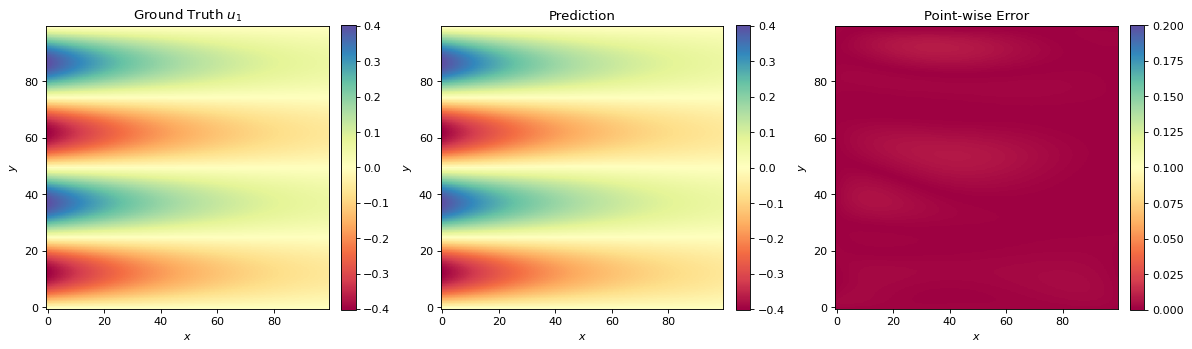

In [140]:
plt.figure(figsize=(15, 25), dpi=80)
u_sol = u2(Y_test,X_test).detach().numpy()
out = u2_net(X_T).reshape(100,100).detach().numpy()
#out = N_p()._eval(X_r).reshape(100,100)
L0_inf = np.max(abs(out.reshape(-1)-u_sol.reshape(-1)))
#Lp_inf = torch.max(abs(poisson_residual(net_s(inp_r),inp_r,omega).reshape(-1)))
L0_mean = (np.mean(abs(out.reshape(-1)-u_sol.reshape(-1))))
print("pred rel. linf-error = {:e}".format(L0_inf))
print("pred rel. l2-error = {:e}".format(L0_mean))
#print("pde res. linf-error = {:e}".format(Lp_inf))
print("pred_rel_std. linf-error = {:e}".format(np.std(abs(out.reshape(-1)-u_sol.reshape(-1)))))
plt.subplot(1,3,1)
plt.imshow(u_sol, cmap="Spectral", origin="lower")
#plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
#plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Ground Truth $u_1$")
#plt.clim(-1,1)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.imshow(out, cmap="Spectral", origin="lower")
#plt.xticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
#plt.yticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Prediction")
#plt.clim(-1,1)
plt.colorbar(fraction=0.046, pad=0.04)
#plt.subplots_adjust(wspace=0, hspace=0)
plt.subplot(1,3,3)
plt.imshow(np.abs(out-u_sol), cmap="Spectral", origin="lower")
#plt.xticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
#plt.yticks(np.linspace(0,len(x)+1,5),np.linspace(-1, 1, 5))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Point-wise Error")
plt.clim(0,0.2)
plt.colorbar(fraction=0.046, pad=0.04)

#plt.gcf().set_size_inches(14,4)
plt.tight_layout()
#plt.savefig(folder + 'pred_error_MSE.png',bbox_inches='tight')